## Load & Inspect Dataset

In [37]:
import pandas as pd

# Load the dataset
df = pd.read_csv(r'C:\Users\xrwon\Downloads\kl-property-price-predictor\data\malaysia_house_price_data_2025.csv')

# Quick overview
df.head()

,Township,Area,State,Tenure,Type,Median_Price,Median_PSF,Transactions
0,SCIENTEX SUNGAI DUA,Tasek Gelugor,Penang,Freehold,Terrace House,331800.0,304.0,593
1,BANDAR PUTRA,Kulai,Johor,Freehold,"Cluster House, Terrace House",590900.0,322.0,519
2,TAMAN LAGENDA TROPIKA TAPAH,Chenderiang,Perak,Freehold,Terrace House,229954.0,130.0,414
3,SCIENTEX JASIN MUTIARA,Bemban,Melaka,Freehold,Terrace House,255600.0,218.0,391
4,TAMAN LAGENDA AMAN,Tapah,Perak,Leasehold,Terrace House,219300.0,168.0,363


In [38]:
df.info()
df.describe(include='all')
df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Township      2000 non-null   object 
 1   Area          2000 non-null   object 
 2   State         2000 non-null   object 
 3   Tenure        2000 non-null   object 
 4   Type          2000 non-null   object 
 5   Median_Price  2000 non-null   float64
 6   Median_PSF    2000 non-null   float64
 7   Transactions  2000 non-null   int64  
dtypes: float64(2), int64(1), object(5)
memory usage: 125.1+ KB


Township        0
Area            0
State           0
Tenure          0
Type            0
Median_Price    0
Median_PSF      0
Transactions    0
dtype: int64

## Clean Column Names

In [39]:
# Standardize column names
df.columns = df.columns.str.lower().str.replace(' ', '_')
df.head()

,township,area,state,tenure,type,median_price,median_psf,transactions
0,SCIENTEX SUNGAI DUA,Tasek Gelugor,Penang,Freehold,Terrace House,331800.0,304.0,593
1,BANDAR PUTRA,Kulai,Johor,Freehold,"Cluster House, Terrace House",590900.0,322.0,519
2,TAMAN LAGENDA TROPIKA TAPAH,Chenderiang,Perak,Freehold,Terrace House,229954.0,130.0,414
3,SCIENTEX JASIN MUTIARA,Bemban,Melaka,Freehold,Terrace House,255600.0,218.0,391
4,TAMAN LAGENDA AMAN,Tapah,Perak,Leasehold,Terrace House,219300.0,168.0,363


## Target Variable Transformation (Log)

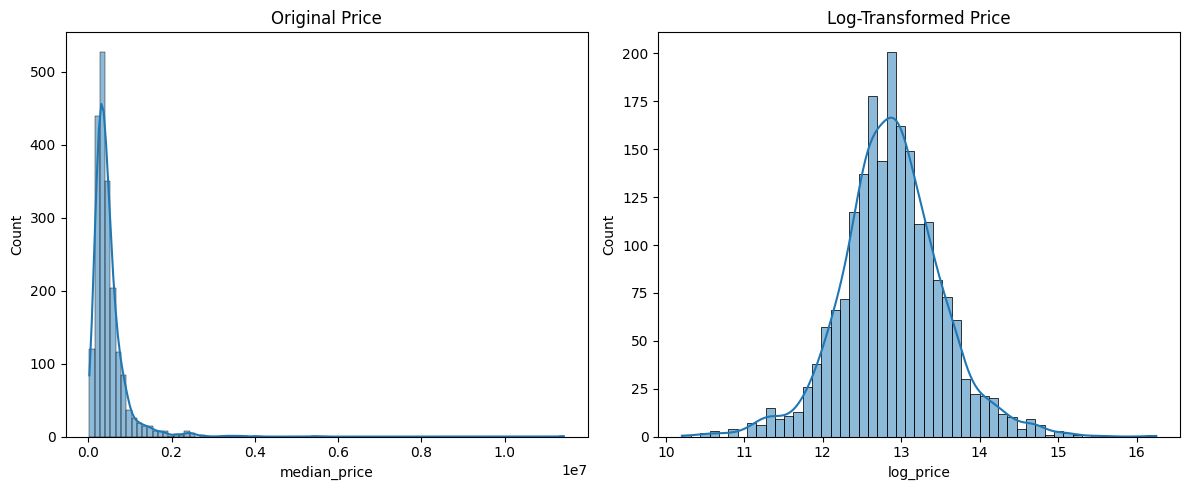

In [40]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Add log-transformed price column
df['log_price'] = np.log1p(df['median_price'])

# Visualize before and after
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(df['median_price'], kde=True)
plt.title("Original Price")

plt.subplot(1, 2, 2)
sns.histplot(df['log_price'], kde=True)
plt.title("Log-Transformed Price")
plt.tight_layout()
plt.show()

🧠 **Why Log Transform Property Prices?**
1. **Real Estate Prices Are Skewed**
-   In most housing markets, price distributions are **right-skewed**:
    -   Many affordable houses
    -   A few extremely expensive ones (luxury condos, bungalows)

🔍 Problem:
Most machine learning models (especially **Linear Regression**) assume the **target variable is normally distributed.** A skewed distribution violates this assumption.

2. **Improve Model Performance**
-   Skewed prices lead to:
    -   Larger residuals (prediction errors)
    -   Models focusing too much on expensive outliers
-   After **log-transforming**, prices become **more normally distributed**, which:
    -   Stabilizes variance
    -   Improves accuracy
    -   Reduces sensitivity to extreme values

3. **Makes Relationships Linear**
    -   Many relationships (e.g., between size and price) become **more linear** after a log transform.
    -   Linear models love this.

## Correlation Heatmap

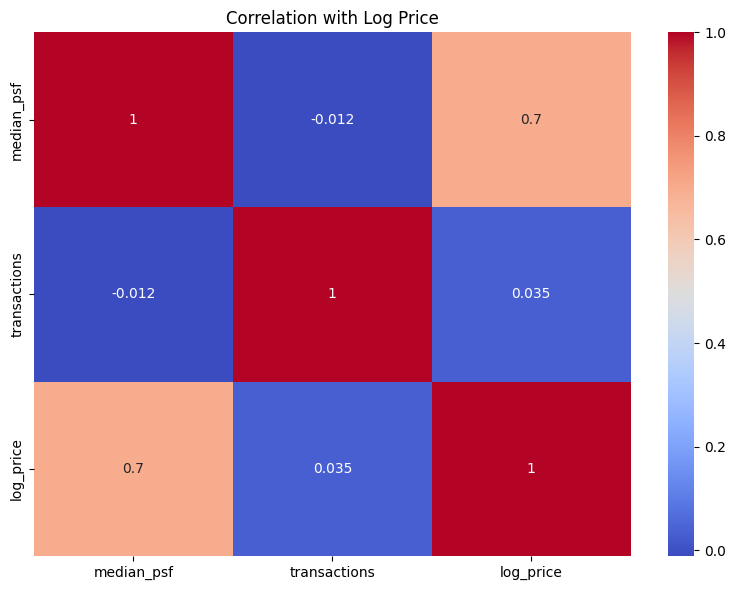

In [41]:
# Check correlation with numeric features
plt.figure(figsize=(8, 6))
sns.heatmap(df[['median_psf', 'transactions', 'log_price']].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation with Log Price')
plt.tight_layout()
plt.show()

## Boxplot

a. By state

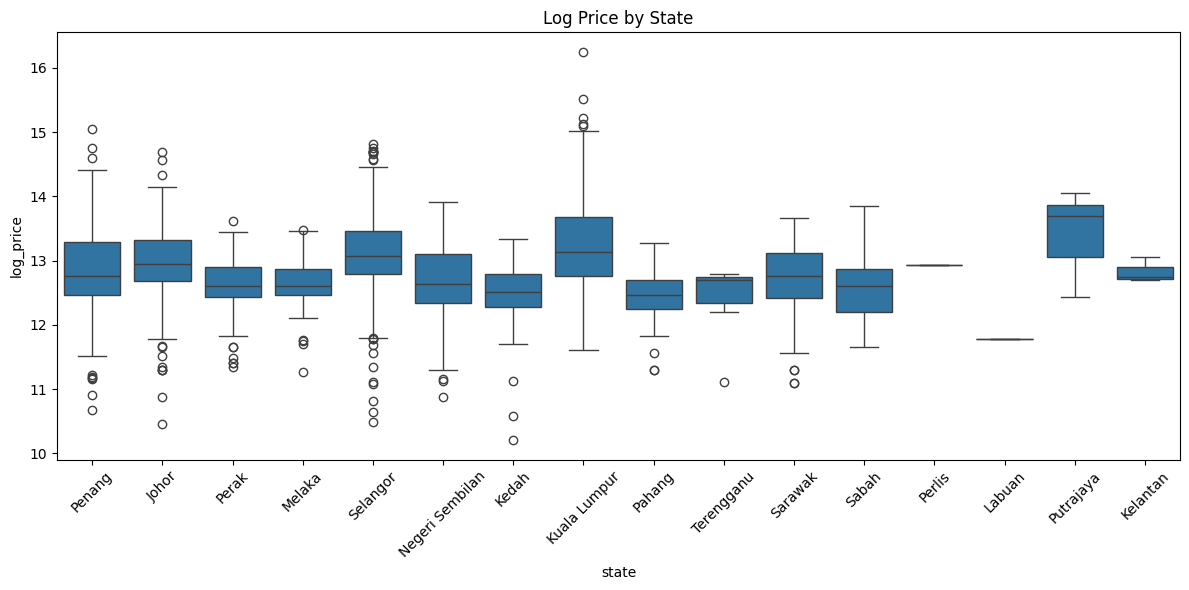

In [42]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='state', y='log_price', data=df)
plt.xticks(rotation=45)
plt.title('Log Price by State')
plt.tight_layout()
plt.show()

b. By type

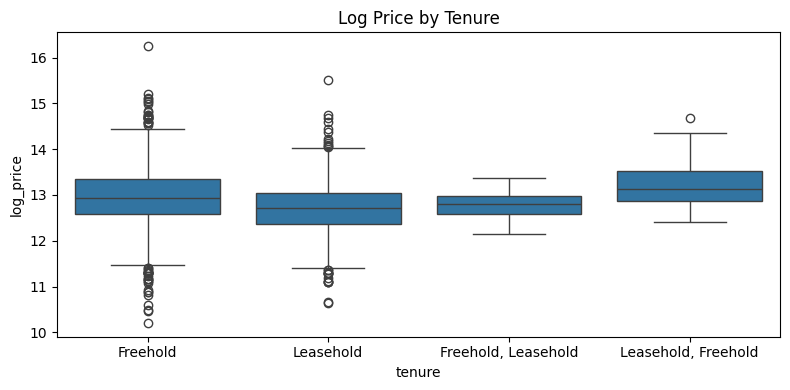

In [43]:
plt.figure(figsize=(8, 4))
sns.boxplot(x='tenure', y='log_price', data=df)
plt.title('Log Price by Tenure')
plt.tight_layout()
plt.show()

## Encode Categorical Variables

In [44]:
# One-hot encode 'type', 'tenure', 'state'
df_encoded = pd.get_dummies(df, columns=['type', 'tenure', 'state'], drop_first=True)

# Optional: handle 'area' by grouping top 10
top_areas = df['area'].value_counts().nlargest(10).index
df_encoded['area_group'] = df['area'].apply(lambda x: x if x in top_areas else 'Other')
df_encoded = pd.get_dummies(df_encoded, columns=['area_group'], drop_first=True)

## Feature Selection

In [45]:
# Drop irrelevant or redundant columns
features = [col for col in df_encoded.columns if col not in ['median_price', 'log_price', 'township', 'area']]

X = df_encoded[features]
y = df_encoded['log_price']

## Train/Test Split and Modeling

In [46]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predict
y_pred = model.predict(X_test)

## Evaluate the Model

In [47]:
# Evaluate performance
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("RMSE (log scale):", rmse)
print("R-squared:", r2)

# Convert predictions back from log
final_predictions = np.expm1(y_pred)

RMSE (log scale): 0.3114166498531313
R-squared: 0.771634111503476


## Actual vs Predicted Plot

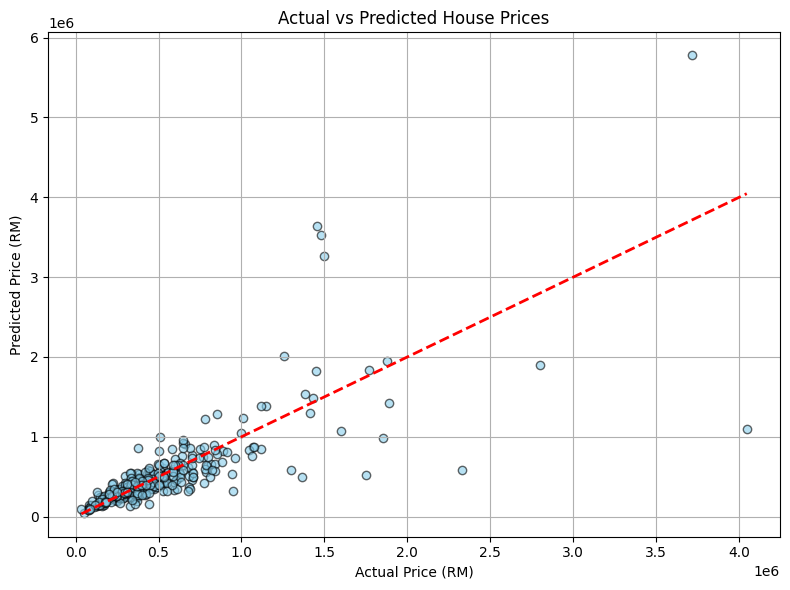

In [48]:
import matplotlib.pyplot as plt
import numpy as np

# Convert log predictions and actuals back to RM
y_test_rm = np.expm1(y_test)
y_pred_rm = np.expm1(y_pred)

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(y_test_rm, y_pred_rm, alpha=0.6, color='skyblue', edgecolors='black')
plt.plot([y_test_rm.min(), y_test_rm.max()],
         [y_test_rm.min(), y_test_rm.max()],
         'r--', linewidth=2)
plt.xlabel('Actual Price (RM)')
plt.ylabel('Predicted Price (RM)')
plt.title('Actual vs Predicted House Prices')
plt.grid(True)
plt.tight_layout()
plt.show()


🧠 **What to Look For:**
-   🔴 **Red dashed line** = perfect predictions
-   🔵 **Dots** = actual vs predicted values
-   🎯 The **closer to the red line**, the better

## Feature Importance Plot

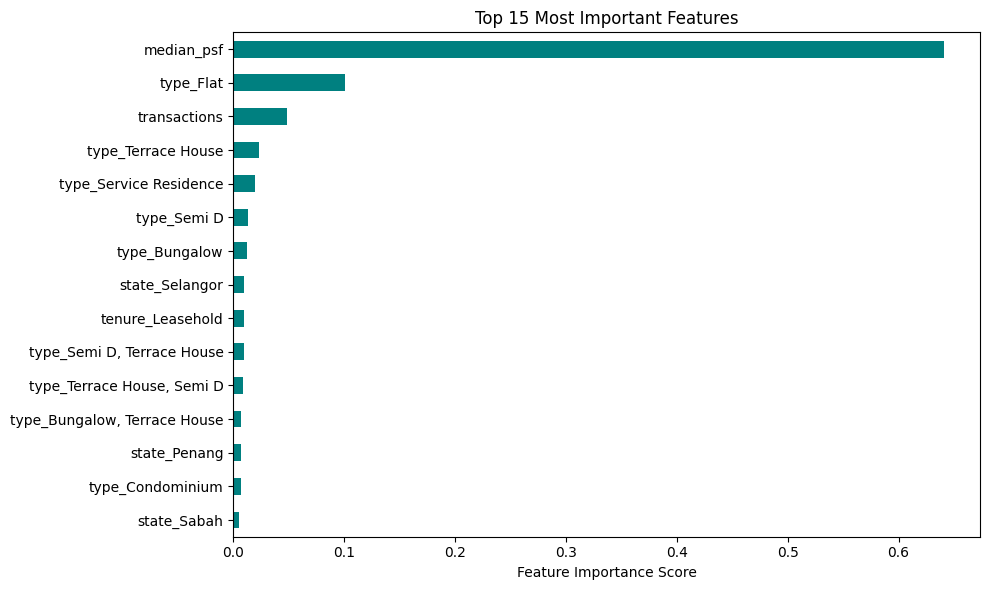

In [49]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Get feature importances from the model
importances = model.feature_importances_

# Match with feature names
feature_names = X.columns
feat_importances = pd.Series(importances, index=feature_names)

# Sort and plot
plt.figure(figsize=(10, 6))
feat_importances.sort_values(ascending=True).tail(15).plot(kind='barh', color='teal')
plt.title("Top 15 Most Important Features")
plt.xlabel("Feature Importance Score")
plt.tight_layout()
plt.show()
